In [8]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 


from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [9]:
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

# Computes the AUC ROC of the classifier.
def generate_auc(X_train, y_train, X_test, y_test,clf_class,**kwargs):
    # Construct a kfolds object
    #random_state = np.random.RandomState(0)
    # Construct training and testing set.
    #X, y = shuffle(X, y, random_state=random_state)
    #n_samples, n_features = X.shape
    #half = int(n_samples/1.2)
    #X_train, X_test = X[:half], X[half:]
    #y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    return(fpr, tpr, roc_auc, thresholds)



def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
        

In [10]:
# read in data
sms = pd.read_csv("spam.csv", usecols=[0, 1], 
	header=0, names=['class_label', 'message'], encoding='latin-1')

x = sms.class_label.value_counts()

print("There are %d ham entries."  % x[0])
print("There are %d spam entries."  % x[1])


sms['class_number'] = sms['class_label'].map({'ham':0, 'spam':1})
sms = sms[['message', 'class_label', 'class_number']]


There are 4825 ham entries.
There are 747 spam entries.


In [13]:
X = sms['message']
y = sms['class_number']
vect = CountVectorizer()
vect.fit(X)
X = vect.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
	train_size=.8, random_state=42)
#X = X.reshape(X.shape[0], 1)
# create CountVectorizer Instance 
vect = CountVectorizer()

#vect.fit(X_train)
#X_train_df = vect.transform(X_train)
X_train_df = X_train
X_test_df = X_test
#X_test_df = vect.transform(X_test)

# dictionary that will cv scores 
cv_scores = {}

# multi
clf_multi = MultinomialNB()
# get 5-fold cross validation scores first
cv_scores['multi'] = cross_val_score(clf_multi, X, y, cv=5)
clf_multi.fit(X_train_df,y_train)

# logistic regression
alpha = .02
clf_LR    = LogisticRegression(C=alpha,penalty='l1')
cv_scores['LR'] = cross_val_score(clf_LR, X, y, cv=5)
clf_LR.fit(X_train_df, y_train)

# SVM - rbf's
clf_svm_rbf = SVC(kernel='rbf', probability=True)
cv_scores['svm_rbf'] = cross_val_score(clf_svm_rbf, X, y, cv=5)
clf_svm_rbf.fit(X_train_df, y_train)

# K-Nearest Neighbors
clf_knn = KNeighborsClassifier(n_neighbors=2, metric='minkowski')
cv_scores['knn'] = cross_val_score(clf_knn, X, y, cv=5)
clf_knn.fit(X_train_df, y_train)

# # split-test scores
scores = {}
scores['multi'] =clf_multi.score(X_test_df,y_test)
scores['LR'] = clf_LR.score(X_test_df, y_test)
scores['svm-rbf'] = clf_svm_rbf.fit(X_test_df, y_test)
scores['knn'] = clf_knn.fit(X_test_df, y_test)


knn
multi
LR


In [ ]:
for clf in cv_scores.keys():
    print("classifier %s: Accuracy: %0.2f (+/- %0.2f)" % ( clf, cv_scores[clf].mean(), cv_scores[clf].std() * 2))

Area under the ROC curve : 0.979216
Area under the ROC curve : 0.933914
Area under the ROC curve : 0.975278
Area under the ROC curve : 0.846114


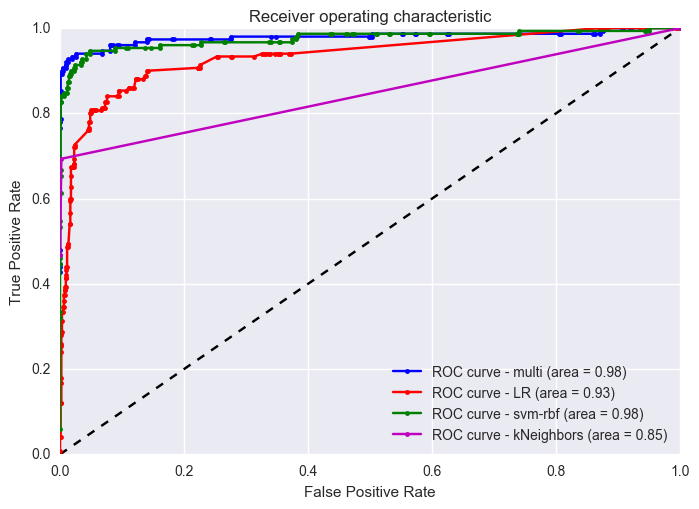

In [12]:


# # *** generate ROC curves ***

# Plotting set up 
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

# MULTINOMIAL
fpr,tpr,roc_auc, thresholds = generate_auc(X_train_df,y_train, X_test_df, y_test, MultinomialNB)
axes.plot(fpr, tpr, '.-b', label='ROC curve - multi (area = %.2f)' % roc_auc)

# Logistic Regression
fpr,tpr,roc_auc, thresholds = generate_auc(X_train_df,y_train, X_test_df, y_test, LogisticRegression, C=alpha,penalty='l1')
axes.plot(fpr, tpr, '.-r', label='ROC curve - LR (area = %.2f)' % roc_auc)

# Support Vector Machine - RBF
fpr,tpr,roc_auc, thresholds = generate_auc(X_train_df,y_train, X_test_df, y_test, SVC, kernel='rbf', probability=True)
axes.plot(fpr, tpr, '.-g', label='ROC curve - svm-rbf (area = %.2f)' % roc_auc)

# K Nearets Neighbors Classifier
fpr,tpr,roc_auc, thresholds = generate_auc(X_train_df,y_train, X_test_df, y_test, 
                                KNeighborsClassifier, n_neighbors=2, metric='minkowski')
axes.plot(fpr, tpr, '.-m', label='ROC curve - kNeighbors (area = %.2f)' % roc_auc)

axes.legend(loc=4)
plt.show()
